In [1]:
#!pip install emoji --upgrade

In [2]:
#!pip install xgboost

In [3]:
#!pip install shap

In [4]:
import os 
import re

In [5]:
import geopandas as gpd
import pandas as pd
import numpy as np
import seaborn as sns
from shapely.geometry import Polygon, LineString, Point
import matplotlib.pyplot as plt

In [6]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, learning_curve, cross_validate

In [7]:
from xgboost import XGBRegressor

In [8]:
import shap
shap.initjs()

/home/gabymhuidobro/.pyenv/versions/3.10.6/envs/le-wagon-rus/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# DATASETS | data_ruscdmx (data_RUS*)

In [9]:
# We can drop 'CVEGEO' and 'geomatry' 
#                or
# use 'CVEGEO' as index

## AGEB | formato shape | agebs

In [10]:
ageb_rural =gpd.read_file('../raw_data/poligono_ageb_rurales_cdmx/poligono_ageb_rurales_cdmx.shp')

In [11]:
ageb_urbana =gpd.read_file('../raw_data/poligono_ageb_urbanas_cdmx/poligono_ageb_urbanas_cdmx.shp')

In [12]:
agebs = pd.concat([ageb_rural, ageb_urbana])

In [13]:
agebs = agebs.drop(columns=['CVE_ENT', 'CVE_MUN', 'CVE_AGEB','CVE_LOC'])

In [14]:
agebs.shape

(2453, 2)

## Dataset features | data_RUS

In [15]:
data_RUS = pd.read_csv('../clean_datasets/data_RUS.csv')

In [16]:
data_RUS.drop(columns='Unnamed: 0', inplace=True)

In [17]:
data_RUS.columns

Index(['CVEGEO', 'Metro', 'Suburbano', 'Metrobus', 'Tren_Liger', 'Trolebus',
       'RTP', 'Trole_elev', 'T_Concesio', 'Ecobici',
       ...
       'PCON_DISC', 'GRAPROES', 'GRAPROES_F', 'GRAPROES_M', 'PEA', 'PEA_F',
       'PEA_M', 'POBREZA', 'POBREZAEX', 'vio_index'],
      dtype='object', length=129)

In [18]:
data_RUS.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2453 entries, 0 to 2452
Columns: 129 entries, CVEGEO to vio_index
dtypes: float64(126), int64(2), object(1)
memory usage: 2.4+ MB


In [19]:
data_ruscdmx = pd.merge(agebs, data_RUS,how= 'left', on=['CVEGEO'])

In [20]:
data_ruscdmx.shape

(2453, 130)

In [21]:
#list of features
transport_features = ['Metro', 'Suburbano', 'Metrobus', 'Tren_Liger', 'Trolebus', 'RTP','Trole_elev', 'T_Concesio', 'Ecobici', 'Cablebus']

population_features = [ 'POBTOT_y', 'POBFEM', 'POBMAS', 
                       'P_0A2', 'P_3A5', 'P_6A11', 'P_12A14', 'P_15A17', 'P_18A24', 'P_25A59', 'P_60YMAS', 
                       'P_0A2_F', 'P_3A5_F', 'P_6A11_F', 'P_12A14_F', 'P_15A17_F', 'P_18A24_F', 'P_25A59_F', 'P_60YMAS_F', 
                       'P_0A2_M', 'P_3A5_M', 'P_6A11_M', 'P_12A14_M', 'P_15A17_M', 'P_18A24_M', 'P_25A59_M', 'P_60YMAS_M', 
                       'P3YM_HLI', 'P3YM_HLI_F', 'P3YM_HLI_M', 'P3HLINHE', 'P3HLINHE_F', 'P3HLINHE_M', 
                       'P3HLI_HE', 'P3HLI_HE_F', 'P3HLI_HE_M', 'P5_HLI', 'P5_HLI_NHE', 'P5_HLI_HE', 
                       'PHOG_IND', 'POB_AFRO', 'POB_AFRO_F', 'POB_AFRO_M', 
                       'PCON_DISC', 
                       'GRAPROES', 'GRAPROES_F', 'GRAPROES_M', 
                       'PEA', 'PEA_F', 'PEA_M', 
                       'HOGJEF_F', 'HOGJEF_M', 
                       'VPH_AUTOM', 'VPH_MOTO', 'VPH_BICI', 
                       'POBREZA', 'POBREZAEX']

urbaninfra_features = ['VIVTOT', 
                       'RECUCALL_C_1', 'RECUCALL_C_2', 'RECUCALL_C_3', 'RECUCALL_C_7', 'RECUCALL_C_8', 'RECUCALL_C_9', 
                       'RAMPAS_C_1', 'RAMPAS_C_2', 'RAMPAS_C_3', 'RAMPAS_C_7', 'RAMPAS_C_8', 'RAMPAS_C_9', 
                       'PASOPEAT_C_1', 'PASOPEAT_C_2', 'PASOPEAT_C_3', 'PASOPEAT_C_7', 'PASOPEAT_C_8', 'PASOPEAT_C_9', 
                       'BANQUETA_C_1', 'BANQUETA_C_2', 'BANQUETA_C_3', 'BANQUETA_C_7', 'BANQUETA_C_8', 'BANQUETA_C_9', 
                       'GUARNICI_C_1', 'GUARNICI_C_2', 'GUARNICI_C_3', 'GUARNICI_C_7', 'GUARNICI_C_8', 'GUARNICI_C_9', 
                       'CICLOVIA_C_1', 'CICLOVIA_C_2', 'CICLOVIA_C_3', 'CICLOVIA_C_7', 'CICLOVIA_C_8', 'CICLOVIA_C_9', 
                       'CICLOCAR_C_1', 'CICLOCAR_C_2', 'CICLOCAR_C_3', 'CICLOCAR_C_7', 'CICLOCAR_C_8', 'CICLOCAR_C_9', 
                       'ALUMPUB_C_1', 'ALUMPUB_C_2', 'ALUMPUB_C_3', 'ALUMPUB_C_7', 'ALUMPUB_C_8', 'ALUMPUB_C_9', 
                       'LETRERO_C_1', 'LETRERO_C_2', 'LETRERO_C_3', 'LETRERO_C_7', 'LETRERO_C_8', 'LETRERO_C_9', 
                       'ARBOLES_C_1', 'ARBOLES_C_2', 'ARBOLES_C_3', 'ARBOLES_C_7', 'ARBOLES_C_8', 'ARBOLES_C_9', 
                       'SEMAPEAT_C_1', 'SEMAPEAT_C_2', 'SEMAPEAT_C_3', 'SEMAPEAT_C_7', 'SEMAPEAT_C_8', 'SEMAPEAT_C_9', 
                       'SEMAAUDI_C_1', 'SEMAAUDI_C_2', 'SEMAAUDI_C_3', 'SEMAAUDI_C_7', 'SEMAAUDI_C_8', 'SEMAAUDI_C_9', 
                       'ESTABICI_C_1', 'ESTABICI_C_2', 'ESTABICI_C_3', 'ESTABICI_C_7', 'ESTABICI_C_8', 'ESTABICI_C_9', 
                       'DRENAJEP_C_1', 'DRENAJEP_C_2', 'DRENAJEP_C_3', 'DRENAJEP_C_7', 'DRENAJEP_C_8', 'DRENAJEP_C_9', 
                       'ACESOPER_C_1', 'ACESOPER_C_2', 'ACESOPER_C_3', 'ACESOPER_C_7', 'ACESOPER_C_8', 'ACESOPER_C_9', 
                       'ACESOAUT_C_1', 'ACESOAUT_C_2', 'ACESOAUT_C_3', 'ACESOAUT_C_7', 'ACESOAUT_C_8', 'ACESOAUT_C_9', 
                       'PUESSEMI_C_1', 'PUESSEMI_C_2', 'PUESSEMI_C_3', 'PUESSEMI_C_7', 'PUESSEMI_C_8', 'PUESSEMI_C_9', 
                       'PUESAMBU_C_1', 'PUESAMBU_C_2', 'PUESAMBU_C_3', 'PUESAMBU_C_7', 'PUESAMBU_C_8', 'PUESAMBU_C_9']

#we are using only 30 
commerce_features = ['Banca múltiple', 'Cafeterías, fuentes de sodas, neverías, refresquerías y similares', 
             'Comercio al por menor de artículos de papelería', 'Comercio al por menor de artículos para la limpieza', 
             'Comercio al por menor de carne de aves', 'Comercio al por menor de carnes rojas', 
             'Comercio al por menor de dulces y materias primas para repostería', 'Comercio al por menor de frutas y verduras frescas', 
             'Comercio al por menor de leche, otros productos lácteos y embutidos', 'Comercio al por menor de otros alimentos', 
             'Comercio al por menor de partes y refacciones nuevas para automóviles, camionetas y camiones', 
             'Comercio al por menor de plantas y flores naturales', 'Comercio al por menor de regalos',
             'Comercio al por menor de ropa, excepto de bebé y lencería', 'Comercio al por menor de teléfonos y otros aparatos de comunicación', 
             'Comercio al por menor en ferreterías y tlapalerías', 'Comercio al por menor en tiendas de abarrotes, ultramarinos y misceláneas', 
             'Consultorios dentales del sector privado', 'Elaboración de tortillas de maíz y molienda de nixtamal', 'Farmacias sin minisúper', 
             'Lavanderías y tintorerías', 'Panificación tradicional', 'Reparación mecánica en general de automóviles y camiones', 
             'Restaurantes con servicio de preparación de alimentos a la carta o de comida corrida', 
             'Restaurantes con servicio de preparación de antojitos', 
             'Restaurantes con servicio de preparación de pizzas, hamburguesas, hot dogs y pollos rostizados para llevar', 
             'Restaurantes con servicio de preparación de tacos y tortas', 'Restaurantes que preparan otro tipo de alimentos para llevar', 
             'Salones y clínicas de belleza y peluquerías', 'Servicios de preparación de otros alimentos para consumo inmediato']

# Explore data

In [22]:
# We can drop 'CVEGEO' and 'geomatry' 
#                or
# use 'CVEGEO' as index

###### using 'data_RUS' insteand of 'data_ruscdmx'

In [23]:
data_RUS.set_index('CVEGEO', inplace=True)

In [24]:
data = data_RUS

In [25]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2453 entries, 090110471 to 0900700011034
Columns: 128 entries, Metro to vio_index
dtypes: float64(126), int64(2)
memory usage: 2.4+ MB


In [26]:
data.columns.tolist()

['Metro',
 'Suburbano',
 'Metrobus',
 'Tren_Liger',
 'Trolebus',
 'RTP',
 'Trole_elev',
 'T_Concesio',
 'Ecobici',
 'Cablebus',
 'RECUCALL_C_1',
 'RECUCALL_C_2',
 'RECUCALL_C_3',
 'RAMPAS_C_1',
 'RAMPAS_C_2',
 'RAMPAS_C_3',
 'PASOPEAT_C_1',
 'PASOPEAT_C_2',
 'PASOPEAT_C_3',
 'BANQUETA_C_1',
 'BANQUETA_C_2',
 'BANQUETA_C_3',
 'GUARNICI_C_1',
 'GUARNICI_C_2',
 'GUARNICI_C_3',
 'CICLOVIA_C_1',
 'CICLOVIA_C_2',
 'CICLOVIA_C_3',
 'CICLOCAR_C_1',
 'CICLOCAR_C_2',
 'CICLOCAR_C_3',
 'ALUMPUB_C_1',
 'ALUMPUB_C_2',
 'ALUMPUB_C_3',
 'LETRERO_C_1',
 'LETRERO_C_2',
 'LETRERO_C_3',
 'ARBOLES_C_1',
 'ARBOLES_C_2',
 'ARBOLES_C_3',
 'SEMAPEAT_C_1',
 'SEMAPEAT_C_2',
 'SEMAPEAT_C_3',
 'SEMAAUDI_C_1',
 'SEMAAUDI_C_2',
 'SEMAAUDI_C_3',
 'ESTABICI_C_1',
 'ESTABICI_C_2',
 'ESTABICI_C_3',
 'DRENAJEP_C_1',
 'DRENAJEP_C_2',
 'DRENAJEP_C_3',
 'ACESOPER_C_1',
 'ACESOPER_C_2',
 'ACESOPER_C_3',
 'ACESOAUT_C_1',
 'ACESOAUT_C_2',
 'ACESOAUT_C_3',
 'PUESSEMI_C_1',
 'PUESSEMI_C_2',
 'PUESSEMI_C_3',
 'PUESAMBU_C_1',
 'P

In [27]:
data.dtypes

Metro         float64
Suburbano     float64
Metrobus      float64
Tren_Liger    float64
Trolebus      float64
               ...   
PEA_F         float64
PEA_M         float64
POBREZA         int64
POBREZAEX       int64
vio_index     float64
Length: 128, dtype: object

In [28]:
data.describe()

,Metro,Suburbano,Metrobus,Tren_Liger,Trolebus,RTP,Trole_elev,T_Concesio,Ecobici,Cablebus,...,PCON_DISC,GRAPROES,GRAPROES_F,GRAPROES_M,PEA,PEA_F,PEA_M,POBREZA,POBREZAEX,vio_index
count,2453.000000,2453.000000,2453.000000,2453.000000,2453.000000,2453.000000,2453.000000,2453.000000,2453.000000,2453.000000,...,2453.000000,2453.000000,2453.000000,2453.000000,2453.000000,2453.000000,2453.000000,2453.000000,2453.000000,2453.000000
mean,0.327985,0.003601,0.125361,0.025492,0.073882,0.430493,0.003300,0.795293,0.052730,0.003002,...,0.049078,0.100430,0.097913,0.103409,0.541053,0.247250,0.293115,1.844272,0.969425,262.866645
std,0.432959,0.047945,0.296088,0.145832,0.208533,0.368757,0.038072,0.280093,0.205249,0.029621,...,0.020795,0.087370,0.083547,0.093338,0.096275,0.051573,0.051278,1.030630,0.181424,180.299965
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.675676,0.000000,0.000000,...,0.036905,0.052408,0.051729,0.053395,0.522497,0.230201,0.287885,1.000000,1.000000,137.087855
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.404762,0.000000,0.906250,0.000000,0.000000,...,0.049706,0.076493,0.074751,0.078261,0.546363,0.248834,0.298673,2.000000,1.000000,228.681284
75%,0.857143,0.000000,0.000000,0.000000,0.000000,0.750000,0.000000,1.000000,0.000000,0.000000,...,0.061876,0.116944,0.114583,0.119919,0.574208,0.271334,0.308756,3.000000,1.000000,353.526453
max,2.000000,1.000000,2.500000,1.096774,1.181818,2.000000,1.000000,2.500000,1.125000,0.666667,...,0.181818,1.227273,1.090909,1.636364,0.851129,0.395349,0.507187,5.000000,2.000000,1369.792320


In [29]:
data['Metro'].idxmax()

'0901700010511'

# Feature scaling and selection | PREPROCESING

## duplicates

In [30]:
#duplicates
len(data)

2453

In [31]:
data.duplicated().sum()

np.int64(21)

## missing data

In [32]:
data.isnull().sum().sort_values(ascending = False)/len(data)

Metro         0.0
Suburbano     0.0
Metrobus      0.0
Tren_Liger    0.0
Trolebus      0.0
             ... 
PEA_F         0.0
PEA_M         0.0
POBREZA       0.0
POBREZAEX     0.0
vio_index     0.0
Length: 128, dtype: float64

In [33]:
data.columns[10:20]

Index(['RECUCALL_C_1', 'RECUCALL_C_2', 'RECUCALL_C_3', 'RAMPAS_C_1',
       'RAMPAS_C_2', 'RAMPAS_C_3', 'PASOPEAT_C_1', 'PASOPEAT_C_2',
       'PASOPEAT_C_3', 'BANQUETA_C_1'],
      dtype='object')

## Outliers

¿Qué podría ser un indicador de un outlier en este dataset?

## Feature scaling

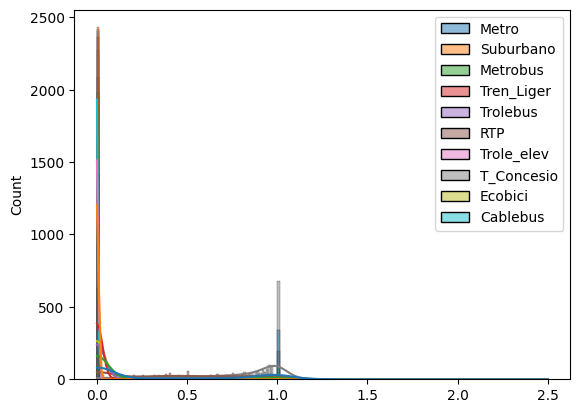

In [34]:
sns.histplot(data[transport_features], bins = 200, kde= True);

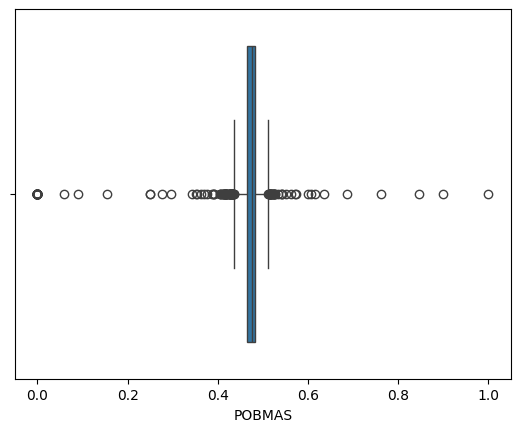

In [35]:
sns.boxplot(data=data, x='POBMAS');

:rotating_light: borrar despu[es de actualizar el dataset

In [36]:
data.shape

(2453, 128)

['CVEGEO', 'geometry', 'Metro', 'Suburbano', 'Metrobus', 'Tren_Liger',
       'Trolebus', 'RTP', 'Trole_elev', 'T_Concesio', 'Ecobici', 'Cablebus',
       'VIVTOT', 'RECUCALL_C_1', 'RECUCALL_C_2', 'RECUCALL_C_3',
       'RECUCALL_C_7', 'RECUCALL_C_8', 'RECUCALL_C_9', 'RAMPAS_C_1',
       'RAMPAS_C_2', 'RAMPAS_C_3', 'RAMPAS_C_7', 'RAMPAS_C_8', 'RAMPAS_C_9',
       'PASOPEAT_C_1', 'PASOPEAT_C_2', 'PASOPEAT_C_3', 'PASOPEAT_C_7',
       'PASOPEAT_C_8', 'PASOPEAT_C_9', 'BANQUETA_C_1', 'BANQUETA_C_2',
       'BANQUETA_C_3', 'BANQUETA_C_7', 'BANQUETA_C_8', 'BANQUETA_C_9',
       'GUARNICI_C_1', 'GUARNICI_C_2', 'GUARNICI_C_3', 'GUARNICI_C_7',
       'GUARNICI_C_8', 'GUARNICI_C_9', 'CICLOVIA_C_1', 'CICLOVIA_C_2',
       'CICLOVIA_C_3', 'CICLOVIA_C_7', 'CICLOVIA_C_8', 'CICLOVIA_C_9',
       'CICLOCAR_C_1', 'CICLOCAR_C_2', 'CICLOCAR_C_3', 'CICLOCAR_C_7',
       'CICLOCAR_C_8', 'CICLOCAR_C_9', 'ALUMPUB_C_1', 'ALUMPUB_C_2',
       'ALUMPUB_C_3', 'ALUMPUB_C_7', 'ALUMPUB_C_8', 'ALUMPUB_C_9',
       'LETRERO_C_1', 'LETRERO_C_2', 'LETRERO_C_3', 'LETRERO_C_7',
       'LETRERO_C_8', 'LETRERO_C_9', 'ARBOLES_C_1', 'ARBOLES_C_2',
       'ARBOLES_C_3', 'ARBOLES_C_7', 'ARBOLES_C_8', 'ARBOLES_C_9',
       'SEMAPEAT_C_1', 'SEMAPEAT_C_2', 'SEMAPEAT_C_3', 'SEMAPEAT_C_7',
       'SEMAPEAT_C_8', 'SEMAPEAT_C_9', 'SEMAAUDI_C_1', 'SEMAAUDI_C_2',
       'SEMAAUDI_C_3', 'SEMAAUDI_C_7', 'SEMAAUDI_C_8', 'SEMAAUDI_C_9',
       'ESTABICI_C_1', 'ESTABICI_C_2', 'ESTABICI_C_3', 'ESTABICI_C_7',
       'ESTABICI_C_8', 'ESTABICI_C_9', 'DRENAJEP_C_1', 'DRENAJEP_C_2',
       'DRENAJEP_C_3', 'DRENAJEP_C_7', 'DRENAJEP_C_8', 'DRENAJEP_C_9',
       'ACESOPER_C_1', 'ACESOPER_C_2', 'ACESOPER_C_3', 'ACESOPER_C_7', 'ACESOPER_C_8', 'ACESOPER_C_9',
       'ACESOAUT_C_1', 'ACESOAUT_C_2', 'ACESOAUT_C_3', 'ACESOAUT_C_7',
       'ACESOAUT_C_8', 'ACESOAUT_C_9', 'PUESSEMI_C_1', 'PUESSEMI_C_2',
       'PUESSEMI_C_3', 'PUESSEMI_C_7', 'PUESSEMI_C_8', 'PUESSEMI_C_9',
       'PUESAMBU_C_1', 'PUESAMBU_C_2', 'PUESAMBU_C_3', 'PUESAMBU_C_7',
       'PUESAMBU_C_8', 'PUESAMBU_C_9', 'POBTOT_y', 'POBFEM', 'POBMAS', 'P_0A2',
       'P_3A5', 'P_6A11', 'P_12A14', 'P_15A17', 'P_18A24', 'P_25A59',
       'P_60YMAS', 'P_0A2_F', 'P_3A5_F', 'P_6A11_F', 'P_12A14_F', 'P_15A17_F',
       'P_18A24_F', 'P_25A59_F', 'P_60YMAS_F', 'P_0A2_M', 'P_3A5_M',
       'P_6A11_M', 'P_12A14_M', 'P_15A17_M', 'P_18A24_M', 'P_25A59_M',
       'P_60YMAS_M', 'P3YM_HLI', 'P3YM_HLI_F', 'P3YM_HLI_M', 'P3HLINHE',
       'P3HLINHE_F', 'P3HLINHE_M', 'P3HLI_HE', 'P3HLI_HE_F', 'P3HLI_HE_M',
       'P5_HLI', 'P5_HLI_NHE', 'P5_HLI_HE', 'PHOG_IND', 'POB_AFRO',
       'POB_AFRO_F', 'POB_AFRO_M', 'PCON_DISC', 'GRAPROES', 'GRAPROES_F',
       'GRAPROES_M', 'PEA', 'PEA_F', 'PEA_M', 'HOGJEF_F', 'HOGJEF_M',
       'VPH_AUTOM', 'VPH_MOTO', 'VPH_BICI', 'POBREZA', 'POBREZAEX',
       'Banca múltiple', 'Cafeterías, fuentes de sodas, neverías, refresquerías y similares',
       'Comercio al por menor de artículos de papelería',
       'Comercio al por menor de artículos para la limpieza',
       'Comercio al por menor de carne de aves',
       'Comercio al por menor de carnes rojas',
       'Comercio al por menor de dulces y materias primas para repostería',
       'Comercio al por menor de frutas y verduras frescas',
       'Comercio al por menor de leche, otros productos lácteos y embutidos',
       'Comercio al por menor de otros alimentos',
       'Comercio al por menor de partes y refacciones nuevas para automóviles, camionetas y camiones',
       'Comercio al por menor de plantas y flores naturales',
       'Comercio al por menor de regalos',
       'Comercio al por menor de ropa, excepto de bebé y lencería',
       'Comercio al por menor de teléfonos y otros aparatos de comunicación',
       'Comercio al por menor en ferreterías y tlapalerías',
       'Comercio al por menor en tiendas de abarrotes, ultramarinos y misceláneas',
       'Consultorios dentales del sector privado',
       'Elaboración de tortillas de maíz y molienda de nixtamal',
       'Farmacias sin minisúper', 'Lavanderías y tintorerías',
       'Panificación tradicional',
       'Reparación mecánica en general de automóviles y camiones',
       'Restaurantes con servicio de preparación de alimentos a la carta o de comida corrida',
       'Restaurantes con servicio de preparación de antojitos',
       'Restaurantes con servicio de preparación de pizzas, hamburguesas, hot dogs y pollos rostizados para llevar',
       'Restaurantes con servicio de preparación de tacos y tortas',
       'Restaurantes que preparan otro tipo de alimentos para llevar',
       'Salones y clínicas de belleza y peluquerías',
       'Servicios de preparación de otros alimentos para consumo inmediato']

In [37]:
#list of numerical (scalable) features
## verificar al agregar mas features
features = data.columns[2:]

In [38]:
data_scaled = data

In [39]:
### outliers could be important in our data

In [40]:
#instanciate
scaler = MinMaxScaler()

#fit the scaler to the features
scaler.fit(data[features])

#scale
data_scaled[features] = scaler.transform(data[features])

data_scaled[40:45]

,Metro,Suburbano,Metrobus,Tren_Liger,Trolebus,RTP,Trole_elev,T_Concesio,Ecobici,Cablebus,...,PCON_DISC,GRAPROES,GRAPROES_F,GRAPROES_M,PEA,PEA_F,PEA_M,POBREZA,POBREZAEX,vio_index
CVEGEO,,,,,,,,,,,,,,,,,,,,,
0901000010065,1.0,0.0,0.000000,0.0,0.0,0.357143,0.0,0.380952,0.0,0.0,...,0.422314,0.031283,0.034862,0.023792,0.704988,0.691622,0.643952,0.6,0.5,0.210802
0901000011063,1.0,0.0,0.061538,0.0,0.0,0.192308,0.0,0.246154,0.0,0.0,...,0.250661,0.033906,0.036630,0.027246,0.664282,0.756819,0.524821,0.2,0.5,0.122711
0901000011542,0.0,0.0,0.000000,0.0,0.0,0.413043,0.0,0.382609,0.0,0.0,...,0.189786,0.028960,0.031631,0.022774,0.680702,0.692141,0.602792,0.2,0.5,0.109362
0901000012358,0.0,0.0,0.000000,0.0,0.0,0.089286,0.0,0.400000,0.0,0.0,...,0.151638,0.087217,0.095145,0.068980,0.647477,0.688348,0.548714,0.2,0.5,0.121318
0901000012057,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.400000,0.0,0.0,...,0.209866,0.069289,0.076202,0.053299,0.622520,0.619082,0.561028,0.2,0.5,0.138775


## Oversampling or Undersampling

In [41]:
## maybe SMOTE ML_02 Data preparation

## Feature engineering

### Encoding

In [42]:
## try with new features, maybe

### Discretizing 

In [43]:
## try with new features. We need this?

### New features

In [44]:
# maybe with commerce
# sum not 'en todas las vialidades' of urban infrastructure features

## Feature correlation

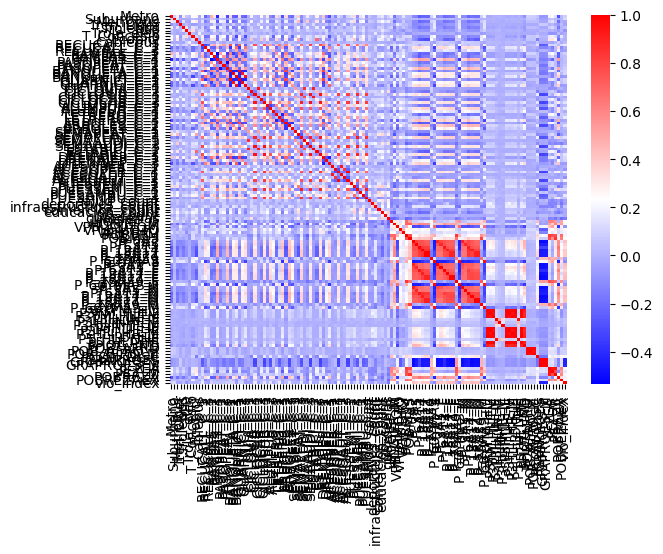

In [45]:
correlation_matrix = data_scaled.corr()

column_names = correlation_matrix.columns

## change commerce feature names

sns.heatmap(correlation_matrix, xticklabels = column_names, yticklabels=column_names, cmap= 'bwr');

In [46]:
#correlation matrix to dataframe
corr_df = correlation_matrix.stack().reset_index()

corr_df.columns = ['feature_1','feature_2','correlation']

no_self_correlation = (corr_df['feature_1'] != corr_df['feature_2'])
corr_df = corr_df[no_self_correlation]

In [47]:
corr_df

,feature_1,feature_2,correlation
1,Metro,Suburbano,0.089333
2,Metro,Metrobus,0.299907
3,Metro,Tren_Liger,-0.096732
4,Metro,Trolebus,0.293473
5,Metro,RTP,0.062433
...,...,...,...
16378,vio_index,PEA,0.214447
16379,vio_index,PEA_F,0.161141
16380,vio_index,PEA_M,0.253187
16381,vio_index,POBREZA,0.197824


In [48]:
#computing absolute correlation
corr_df['absolute_correlation'] = np.abs(corr_df['correlation'])

#top 5 most correlated pairs
corr_df.sort_values(by='absolute_correlation', ascending=False).head(30)

,feature_1,feature_2,correlation,absolute_correlation
12770,P_18A24_M,P_15A17_M,1.000000,1.000000
12643,P_15A17_M,P_18A24_M,1.000000,1.000000
10579,P_15A17,P_18A24,1.000000,1.000000
11611,P_15A17_F,P_18A24_F,1.000000,1.000000
11738,P_18A24_F,P_15A17_F,1.000000,1.000000
10706,P_18A24,P_15A17,1.000000,1.000000
13164,P3YM_HLI,P3HLI_HE,0.999753,0.999753
13926,P3HLI_HE,P3YM_HLI,0.999753,0.999753
14321,P5_HLI,P5_HLI_HE,0.999734,0.999734
14575,P5_HLI_HE,P5_HLI,0.999734,0.999734


In [49]:
## a lot of urban infra are correlated :(

In [50]:
data.shape

(2453, 128)

# **MODEL** | XGBoost

In [51]:
#Ready X and y

# X = data[['Metro', 'Suburbano', 'Metrobus', 'Tren_Liger', 'Trolebus', 'RTP',
#        'Trole_elev', 'T_Concesio', 'Ecobici', 'Cablebus', 'VIVTOT',
#        'RECUCALL_C_1', 'RECUCALL_C_2', 'RECUCALL_C_3', 'RECUCALL_C_7',
#        'RECUCALL_C_8', 'RECUCALL_C_9', 'RAMPAS_C_1', 'RAMPAS_C_2',
#        'RAMPAS_C_3', 'RAMPAS_C_7', 'RAMPAS_C_8', 'RAMPAS_C_9', 'PASOPEAT_C_1',
#        'PASOPEAT_C_2', 'PASOPEAT_C_3', 'PASOPEAT_C_7', 'PASOPEAT_C_8',
#        'PASOPEAT_C_9', 'BANQUETA_C_1', 'BANQUETA_C_2', 'BANQUETA_C_3',
#        'BANQUETA_C_7', 'BANQUETA_C_8', 'BANQUETA_C_9', 'GUARNICI_C_1',
#        'GUARNICI_C_2', 'GUARNICI_C_3', 'GUARNICI_C_7', 'GUARNICI_C_8',
#        'GUARNICI_C_9', 'CICLOVIA_C_1', 'CICLOVIA_C_2', 'CICLOVIA_C_3',
#        'CICLOVIA_C_7', 'CICLOVIA_C_8', 'CICLOVIA_C_9', 'CICLOCAR_C_1',
#        'CICLOCAR_C_2', 'CICLOCAR_C_3', 'CICLOCAR_C_7', 'CICLOCAR_C_8', 'CICLOCAR_C_9',
#        'ALUMPUB_C_1', 'ALUMPUB_C_2', 'ALUMPUB_C_3', 'ALUMPUB_C_7',
#        'ALUMPUB_C_8', 'ALUMPUB_C_9', 'LETRERO_C_1', 'LETRERO_C_2',
#        'LETRERO_C_3', 'LETRERO_C_7', 'LETRERO_C_8', 'LETRERO_C_9',
#        'ARBOLES_C_1', 'ARBOLES_C_2', 'ARBOLES_C_3', 'ARBOLES_C_7',
#        'ARBOLES_C_8', 'ARBOLES_C_9', 'SEMAPEAT_C_1', 'SEMAPEAT_C_2',
#        'SEMAPEAT_C_3', 'SEMAPEAT_C_7', 'SEMAPEAT_C_8', 'SEMAPEAT_C_9',
#        'SEMAAUDI_C_1', 'SEMAAUDI_C_2', 'SEMAAUDI_C_3', 'SEMAAUDI_C_7',
#        'SEMAAUDI_C_8', 'SEMAAUDI_C_9', 'ESTABICI_C_1', 'ESTABICI_C_2',
#        'ESTABICI_C_3', 'ESTABICI_C_7', 'ESTABICI_C_8', 'ESTABICI_C_9',
#        'DRENAJEP_C_1', 'DRENAJEP_C_2', 'DRENAJEP_C_3', 'DRENAJEP_C_7',
#        'DRENAJEP_C_8', 'DRENAJEP_C_9', 'ACESOPER_C_1', 'ACESOPER_C_2',
#        'ACESOPER_C_3', 'ACESOPER_C_7', 'ACESOPER_C_8','ACESOPER_C_8', 'ACESOPER_C_9', 'ACESOAUT_C_1', 'ACESOAUT_C_2',
#        'ACESOAUT_C_3', 'ACESOAUT_C_7', 'ACESOAUT_C_8', 'ACESOAUT_C_9',
#        'PUESSEMI_C_1', 'PUESSEMI_C_2', 'PUESSEMI_C_3', 'PUESSEMI_C_7',
#        'PUESSEMI_C_8', 'PUESSEMI_C_9', 'PUESAMBU_C_1', 'PUESAMBU_C_2',
#        'PUESAMBU_C_3', 'PUESAMBU_C_7', 'PUESAMBU_C_8', 'PUESAMBU_C_9',
#        'POBTOT', 'POBFEM', 'POBMAS', 'P_0A2', 'P_3A5', 'P_6A11', 'P_12A14',
#        'P_15A17', 'P_18A24', 'P_25A59', 'P_60YMAS', 'P_0A2_F', 'P_3A5_F',
#        'P_6A11_F', 'P_12A14_F', 'P_15A17_F', 'P_18A24_F', 'P_25A59_F',
#        'P_60YMAS_F', 'P_0A2_M', 'P_3A5_M', 'P_6A11_M', 'P_12A14_M',
#        'P_15A17_M', 'P_18A24_M', 'P_25A59_M', 'P_60YMAS_M', 'P3YM_HLI',
#        'P3YM_HLI_F', 'P3YM_HLI_M', 'P3HLINHE', 'P3HLINHE_F', 'P3HLINHE_M', 'P3HLI_HE', 'P3HLI_HE_F',
#        'P3HLI_HE_M', 'P5_HLI', 'P5_HLI_NHE', 'P5_HLI_HE', 'PHOG_IND',
#        'POB_AFRO', 'POB_AFRO_F', 'POB_AFRO_M', 'PCON_DISC', 'GRAPROES',
#        'GRAPROES_F', 'GRAPROES_M', 'PEA', 'PEA_F', 'PEA_M', 'HOGJEF_F',
#        'HOGJEF_M', 'VPH_AUTOM', 'VPH_MOTO', 'VPH_BICI', 'POBREZA', 'POBREZAEX',
#        'com_1', 'com_2', 'com_3', 'com_4', 'com_5', 'com_6', 'com_7', 'com_8',
#        'com_9', 'com_10', 'com_11', 'com_12', 'com_13', 'com_14', 'com_15',
#        'com_16', 'com_17', 'com_18', 'com_19', 'com_19', 'com_20', 'com_21',
#        'com_22', 'com_23', 'com_24', 'com_25', 'com_26', 'com_27', 'com_28', 'com_29',
#        'salud_count', 'deportivos_count', 'infraestructura_count',
#        'comercios_count', 'educacion_count', 'pp_count', 'guarderias']]
X = data_scaled.drop(columns='vio_index')
y = data_scaled['vio_index']

# split into train and test (30%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)

# split tran into X_val and y_val (15%) THIS IS FOR THE XGBOOST MODEL
X_train, X_val, y_train, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state = 42)

In [52]:
my_list =  X.columns.tolist()
duplicates = {num:my_list.count(num) for num in my_list}

# printing the element with count greater than 1
for key, value in duplicates.items():
    if value > 1:
        print(key, value)

In [53]:
X.columns.nunique()

127

In [54]:
len(X.columns)

127

In [55]:
#XGBoost is sensitive to outliers

In [56]:
#instantiate model 
xgb_reg = XGBRegressor(n_estimators = 100 ,max_depth= 5, learning_rate=0.1)


## **Cross validation**

In [57]:
# Cross validation
model = xgb_reg
cv_results = cross_validate(model, X , y, cv=5,
                           scoring=['max_error',
                                   'r2',
                                   'neg_root_mean_squared_error',
                                   'neg_mean_squared_error'])

In [58]:
cv_results

{'fit_time': array([0.77191949, 0.85411644, 1.6167357 , 0.94571877, 1.00204587]),
 'score_time': array([0.03853822, 0.03517365, 0.03542757, 0.03495908, 0.0419414 ]),
 'test_max_error': array([-0.37829307, -0.61209986, -0.36106553, -0.51723935, -0.38638993]),
 'test_r2': array([0.63583067, 0.60973826, 0.24686208, 0.55912228, 0.59925628]),
 'test_neg_root_mean_squared_error': array([-0.07144315, -0.08146813, -0.08677819, -0.10826848, -0.07695039]),
 'test_neg_mean_squared_error': array([-0.00510412, -0.00663706, -0.00753045, -0.01172206, -0.00592136])}

In [59]:
print('fit time = ', cv_results['fit_time'].mean())
print('score time = ', cv_results['score_time'].mean())

fit time =  1.0381072521209718
score time =  0.03720798492431641


In [60]:
print('MaxE = ', cv_results['test_max_error'].mean())
print('R2 = ',cv_results['test_r2'].mean())
print('RMSE = ',cv_results['test_neg_root_mean_squared_error'].mean())
print('MSE = ',cv_results['test_neg_mean_squared_error'].mean())

MaxE =  -0.45101754750284356
R2 =  0.5301619148801977
RMSE =  -0.0849816689158481
MSE =  -0.0073830122301454335


In [61]:
# print(cv_results['test_score'])
# print(cv_results['score_time'])
# cv_results['test_score'].mean()

## **Learning curves**

In [62]:
#  ?
train_sizes = [25,50,75,100,250,500,750,1000,1150]

# Get train scores (R2), train sizes, and validation scores using `learning_curve`
train_sizes, train_scores, test_scores = learning_curve(
    estimator=xgb_reg, X=X, y=y, train_sizes=train_sizes, cv=5)

# Take the mean of cross-validated train scores and validation scores
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

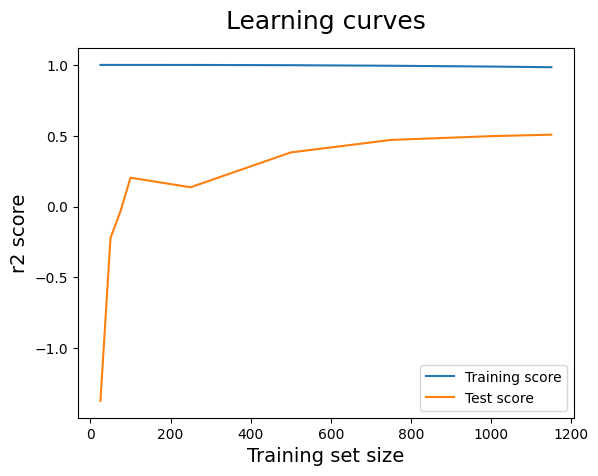

In [63]:
plt.plot(train_sizes, train_scores_mean, label = 'Training score')
plt.plot(train_sizes, test_scores_mean, label = 'Test score')
plt.ylabel('r2 score', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves', fontsize = 18, y = 1.03)
plt.legend()

## **XGBoost model**

In [64]:
# split tran into X_val and y_val (15%) THIS IS FOR THE XGBOOST MODEL
X_train_02, X_val_02, y_train_02, y_val_02 = train_test_split(X, y, test_size=0.2, random_state = 42)

In [65]:
xgb_reg.fit(X, y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [66]:
# import pickle
# file_name = "xgb_reg.pkl"
# # save
# pickle.dump(xgb_reg, open(file_name, "wb"))
# # load
# #xgb_model_loaded = pickle.load(open(file_name, "rb"))

In [67]:
y_predict = xgb_reg.predict(X)

In [68]:
y

CVEGEO
090110471        0.000000
090101326        0.000000
090090539        0.000000
090090524        0.000000
090090115        0.000000
                   ...   
0900700012564    0.384759
0900700012615    0.439599
0900700012969    0.144105
0900700013721    0.258088
0900700011034    0.382883
Name: vio_index, Length: 2453, dtype: float64

In [69]:
# #evaluate the model's performance
# score = xgb_reg.score(X_test, y_test)
# score

In [70]:
# y_pred = xgb_reg.predict(X_val)
# y_pred

## **SHAP**

In [71]:
#creating a SHAP explainer
explainer = shap.Explainer(xgb_reg)

In [72]:
#Calculate the SHAP values
shape_values_01 = explainer(X)
shape_values_02 = explainer(X_test)

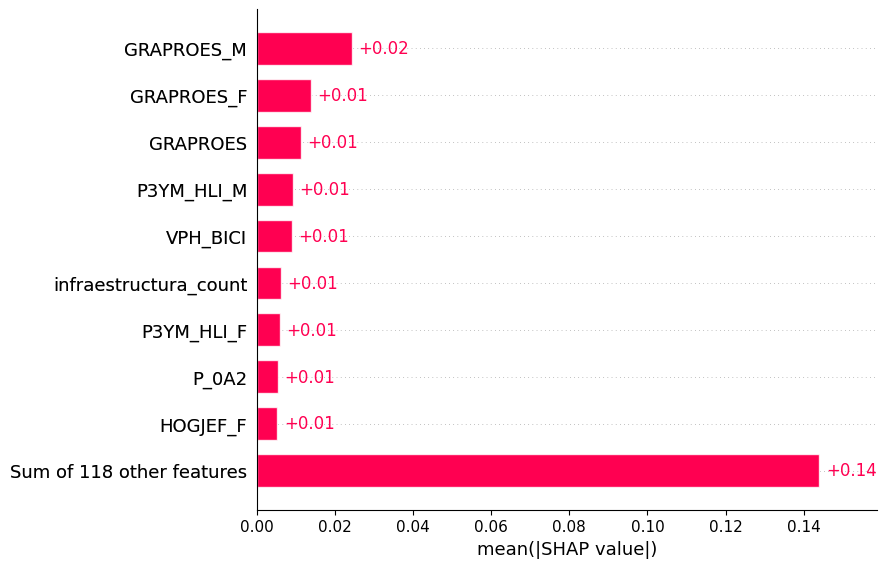

In [73]:
shap.plots.bar(shape_values_02, max_display=10)

In [74]:
y.mean()

np.float64(0.19190255400377362)

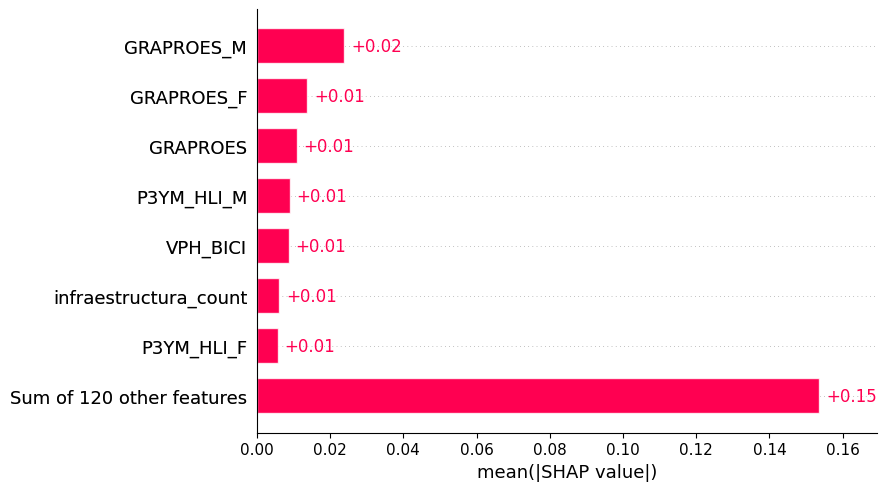

In [75]:
#plot
shap.plots.bar(shape_values_01, max_display=8)

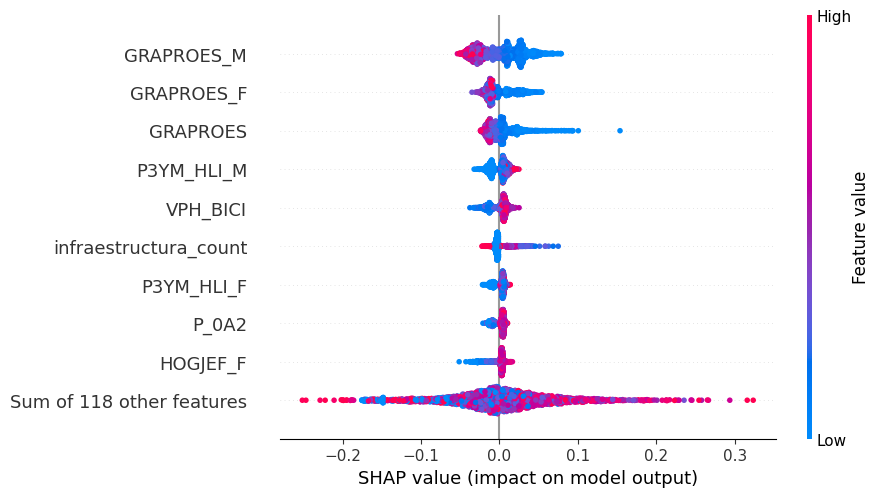

In [76]:
shap.plots.beeswarm(shape_values_01, max_display=10)

In [ ]:
shap.plots.heatmap(shape_values_01, max_display=10)

# pusheando

In [ ]:
#! git status

In [ ]:
!git add RUS_preprocesing_model.ipynb

!git commit -m 'shap on model'

!git push origin main

In [ ]:
#'Metro', 'Suburbano', 'Metrobus', 'Tren_Liger', 'Trolebus', 'RTP',
#        'Trole_elev', 'T_Concesio', 'Ecobici', 'Cablebus', 'VIVTOT',
#        'RECUCALL_C_1', 'RECUCALL_C_2', 'RECUCALL_C_3', 'RECUCALL_C_7',
#        'RECUCALL_C_8', 'RECUCALL_C_9', 'RAMPAS_C_1', 'RAMPAS_C_2',
#        'RAMPAS_C_3', 'RAMPAS_C_7', 'RAMPAS_C_8', 'RAMPAS_C_9', 'PASOPEAT_C_1',
#        'PASOPEAT_C_2', 'PASOPEAT_C_3', 'PASOPEAT_C_7', 'PASOPEAT_C_8',
#        'PASOPEAT_C_9', 'BANQUETA_C_1', 'BANQUETA_C_2', 'BANQUETA_C_3',
#        'BANQUETA_C_7', 'BANQUETA_C_8', 'BANQUETA_C_9', 'GUARNICI_C_1',
#        'GUARNICI_C_2', 'GUARNICI_C_3', 'GUARNICI_C_7', 'GUARNICI_C_8',
#        'GUARNICI_C_9', 'CICLOVIA_C_1', 'CICLOVIA_C_2', 'CICLOVIA_C_3',
#        'CICLOVIA_C_7', 'CICLOVIA_C_8', 'CICLOVIA_C_9', 'CICLOCAR_C_1',
#        'CICLOCAR_C_2', 'CICLOCAR_C_3', 'CICLOCAR_C_7', 'CICLOCAR_C_8', 'CICLOCAR_C_9',
#        'ALUMPUB_C_1', 'ALUMPUB_C_2', 'ALUMPUB_C_3', 'ALUMPUB_C_7',
#        'ALUMPUB_C_8', 'ALUMPUB_C_9', 'LETRERO_C_1', 'LETRERO_C_2',
#        'LETRERO_C_3', 'LETRERO_C_7', 'LETRERO_C_8', 'LETRERO_C_9',
#        'ARBOLES_C_1', 'ARBOLES_C_2', 'ARBOLES_C_3', 'ARBOLES_C_7',
#        'ARBOLES_C_8', 'ARBOLES_C_9', 'SEMAPEAT_C_1', 'SEMAPEAT_C_2',
#        'SEMAPEAT_C_3', 'SEMAPEAT_C_7', 'SEMAPEAT_C_8', 'SEMAPEAT_C_9',
#        'SEMAAUDI_C_1', 'SEMAAUDI_C_2', 'SEMAAUDI_C_3', 'SEMAAUDI_C_7',
#        'SEMAAUDI_C_8', 'SEMAAUDI_C_9', 'ESTABICI_C_1', 'ESTABICI_C_2',
#        'ESTABICI_C_3', 'ESTABICI_C_7', 'ESTABICI_C_8', 'ESTABICI_C_9',
#        'DRENAJEP_C_1', 'DRENAJEP_C_2', 'DRENAJEP_C_3', 'DRENAJEP_C_7',
#        'DRENAJEP_C_8', 'DRENAJEP_C_9', 'ACESOPER_C_1', 'ACESOPER_C_2',
#        'ACESOPER_C_3', 'ACESOPER_C_7', 'ACESOPER_C_8','ACESOPER_C_8', 'ACESOPER_C_9', 'ACESOAUT_C_1', 'ACESOAUT_C_2',
#        'ACESOAUT_C_3', 'ACESOAUT_C_7', 'ACESOAUT_C_8', 'ACESOAUT_C_9',
#        'PUESSEMI_C_1', 'PUESSEMI_C_2', 'PUESSEMI_C_3', 'PUESSEMI_C_7',
#        'PUESSEMI_C_8', 'PUESSEMI_C_9', 'PUESAMBU_C_1', 'PUESAMBU_C_2',
#        'PUESAMBU_C_3', 'PUESAMBU_C_7', 'PUESAMBU_C_8', 'PUESAMBU_C_9',
#        'POBTOT', 'POBFEM', 'POBMAS', 'P_0A2', 'P_3A5', 'P_6A11', 'P_12A14',
#        'P_15A17', 'P_18A24', 'P_25A59', 'P_60YMAS', 'P_0A2_F', 'P_3A5_F',
#        'P_6A11_F', 'P_12A14_F', 'P_15A17_F', 'P_18A24_F', 'P_25A59_F',
#        'P_60YMAS_F', 'P_0A2_M', 'P_3A5_M', 'P_6A11_M', 'P_12A14_M',
#        'P_15A17_M', 'P_18A24_M', 'P_25A59_M', 'P_60YMAS_M', 'P3YM_HLI',
#        'P3YM_HLI_F', 'P3YM_HLI_M', 'P3HLINHE', 'P3HLINHE_F', 'P3HLINHE_M', 'P3HLI_HE', 'P3HLI_HE_F',
#        'P3HLI_HE_M', 'P5_HLI', 'P5_HLI_NHE', 'P5_HLI_HE', 'PHOG_IND',
#        'POB_AFRO', 'POB_AFRO_F', 'POB_AFRO_M', 'PCON_DISC', 'GRAPROES',
#        'GRAPROES_F', 'GRAPROES_M', 'PEA', 'PEA_F', 'PEA_M', 'HOGJEF_F',
#        'HOGJEF_M', 'VPH_AUTOM', 'VPH_MOTO', 'VPH_BICI', 'POBREZA', 'POBREZAEX',
#        'com_1', 'com_2', 'com_3', 'com_4', 'com_5', 'com_6', 'com_7', 'com_8',
#        'com_9', 'com_10', 'com_11', 'com_12', 'com_13', 'com_14', 'com_15',
#        'com_16', 'com_17', 'com_18', 'com_19', 'com_19', 'com_20', 'com_21',
#        'com_22', 'com_23', 'com_24', 'com_25', 'com_26', 'com_27', 'com_28', 'com_29',
#        'salud_count', 'deportivos_count', 'infraestructura_count',
#        'comercios_count', 'educacion_count', 'pp_count', 'guarderias']